<a href="https://colab.research.google.com/github/BoHye0202/DeepLearning/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN 구현하기
- Tom과 Jerry 데이터 활용
- 데이터 출처: 캐글 (https://www.kaggle.com/vijayjoyz/tom-jerry-detection)

## Library Load

In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [2]:
!pip install -q imageio # GIF만들기

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## dataset load and pre-processing

#### Kaggle 데이터 가져오기

In [5]:
# from google.colab import files
# files.upload()

In [6]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [7]:
# !kaggle datasets download -d vijayjoyz/tom-jerry-detection

In [8]:
# !unzip tom-jerry-detection.zip

#### Data Load and Pre-processing

In [9]:
import cv2
from IPython.display import Image

angry = '/content/train/train/angry'
happy = '/content/train/train/happy'
sad = '/content/train/train/sad'
surprised = '/content/train/train/surprised'
unknown = '/content/train/train/unknown'

a = cv2.imread('/content/train/train/angry/frame231.jpg')
h = cv2.imread('/content/train/train/happy/frame190.jpg')
print(a.shape, h.shape)

(720, 1280, 3) (720, 1280, 3)


In [10]:
folder = [angry, happy, sad, surprised, unknown]
img_h, img_w, num_channels = 512, 512, 3

img_path = []
for i in folder:
  file_list = os.listdir(i)
  file_list_jpg = [i+'/'+file for file in file_list if file.endswith(".jpg")]
  img_path += file_list_jpg
  print(len(file_list_jpg))
print(len(img_path))
print(img_path)

37
37
40
68
116
298
['/content/train/train/angry/frame261.jpg', '/content/train/train/angry/frame255.jpg', '/content/train/train/angry/frame154.jpg', '/content/train/train/angry/frame146.jpg', '/content/train/train/angry/frame149.jpg', '/content/train/train/angry/frame227.jpg', '/content/train/train/angry/frame131.jpg', '/content/train/train/angry/frame239.jpg', '/content/train/train/angry/frame20.jpg', '/content/train/train/angry/frame9.jpg', '/content/train/train/angry/frame81.jpg', '/content/train/train/angry/frame147.jpg', '/content/train/train/angry/frame256.jpg', '/content/train/train/angry/frame15.jpg', '/content/train/train/angry/frame144.jpg', '/content/train/train/angry/frame231.jpg', '/content/train/train/angry/frame150.jpg', '/content/train/train/angry/frame132.jpg', '/content/train/train/angry/frame228.jpg', '/content/train/train/angry/frame80.jpg', '/content/train/train/angry/frame4.jpg', '/content/train/train/angry/frame238.jpg', '/content/train/train/angry/frame237.jpg'

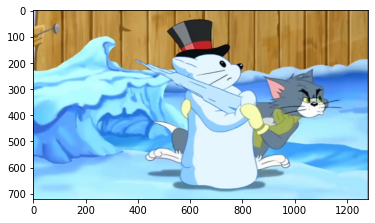

In [11]:
a = cv2.imread('/content/train/train/angry/frame46.jpg')
plt.imshow(a[:,:,::-1])

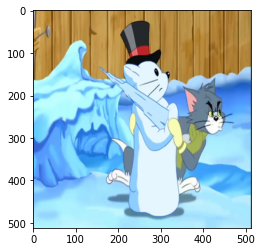

In [12]:
b = cv2.resize(a, (img_h, img_w))
plt.imshow(b[:,:,::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


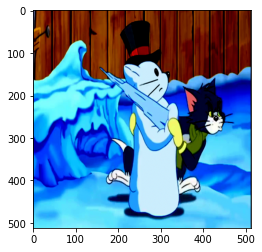

In [13]:
c = (b-127.5)/127.5
plt.imshow(c[:,:,::-1])

In [14]:
max_value, min_value = -100,256
for i in img_path:
  img = cv2.imread(i)
  tmp = np.array(img)
  # print(tmp)
  max_value = max(np.max(tmp), max_value)
  min_value = min(np.min(tmp), min_value)
print(max_value, min_value)

255 0


In [15]:
train = []
for i in img_path:
  img = cv2.imread(i)
  img_input = cv2.resize(img, (img_h, img_w))
  img_input = (img_input-127.5)/127.5
  # img_input = img_input[np.newaxis, ...].astype(np.float32) # 차원추가
  img_input = tf.constant(img_input) # numpy array를 tensor로 변경

  train.append(img_input)
print(len(train))
# train

298


In [16]:
BUFFER_SIZE = 3000 # 60000
BATCH_SIZE = 16 # OOM때문에 배치사이즈를 256-> 32로 조절했습니다.

train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator Model

In [17]:
# Generator
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(16*16*1024, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((16,16,1024)))
  assert model.output_shape == (None, 16, 16, 1024) # 주목: 배치사이즈로 None이 주어집니다.
  
  # 16*16*1024 => 32*32*512
  model.add(layers.Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 512)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 32*32*512 => 64*64*256
  model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 64*64*256 => 128*128*128
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 128, 128, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 128*128*128 => 256*256*64
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 256, 256, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 256*256*64 => 512*512*32
  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 512, 512, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 512*512*32 => 512*512*3
  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 512, 512, 3)

  return model

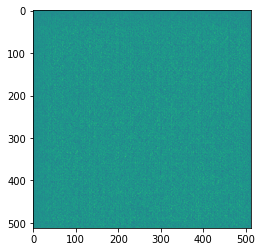

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :,:,0])

## Discriminator Model

In [19]:
def make_discriminator_model():
  
  # 512*512*3 => 256*256*32
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=[512,512,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 256*256*32 => 128*128*64 
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 128*128*64 => 64*64*128
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 64*64*128 => 32*32*256
  model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 32*32*256 => 16*16*512
  model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 16*16*512 => 1
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.722049e-05]], shape=(1, 1), dtype=float32)


## Loss Function

In [21]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 체크포인트 저장

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [25]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
@tf.function # 함수 컴파일
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    if (epoch+1) % 5 ==0:
      generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16,16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

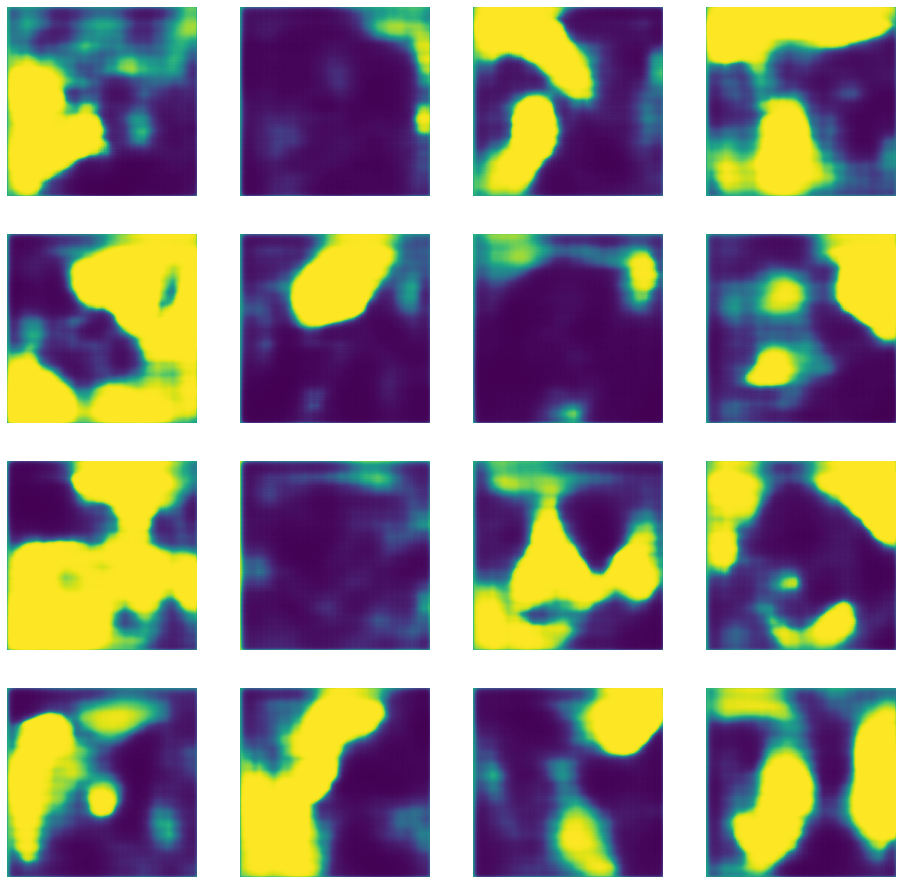

CPU times: user 30min 44s, sys: 23min 44s, total: 54min 29s
Wall time: 54min 52s


In [29]:
%%time
train(train_dataset, EPOCHS)

## GIF 생성

In [30]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

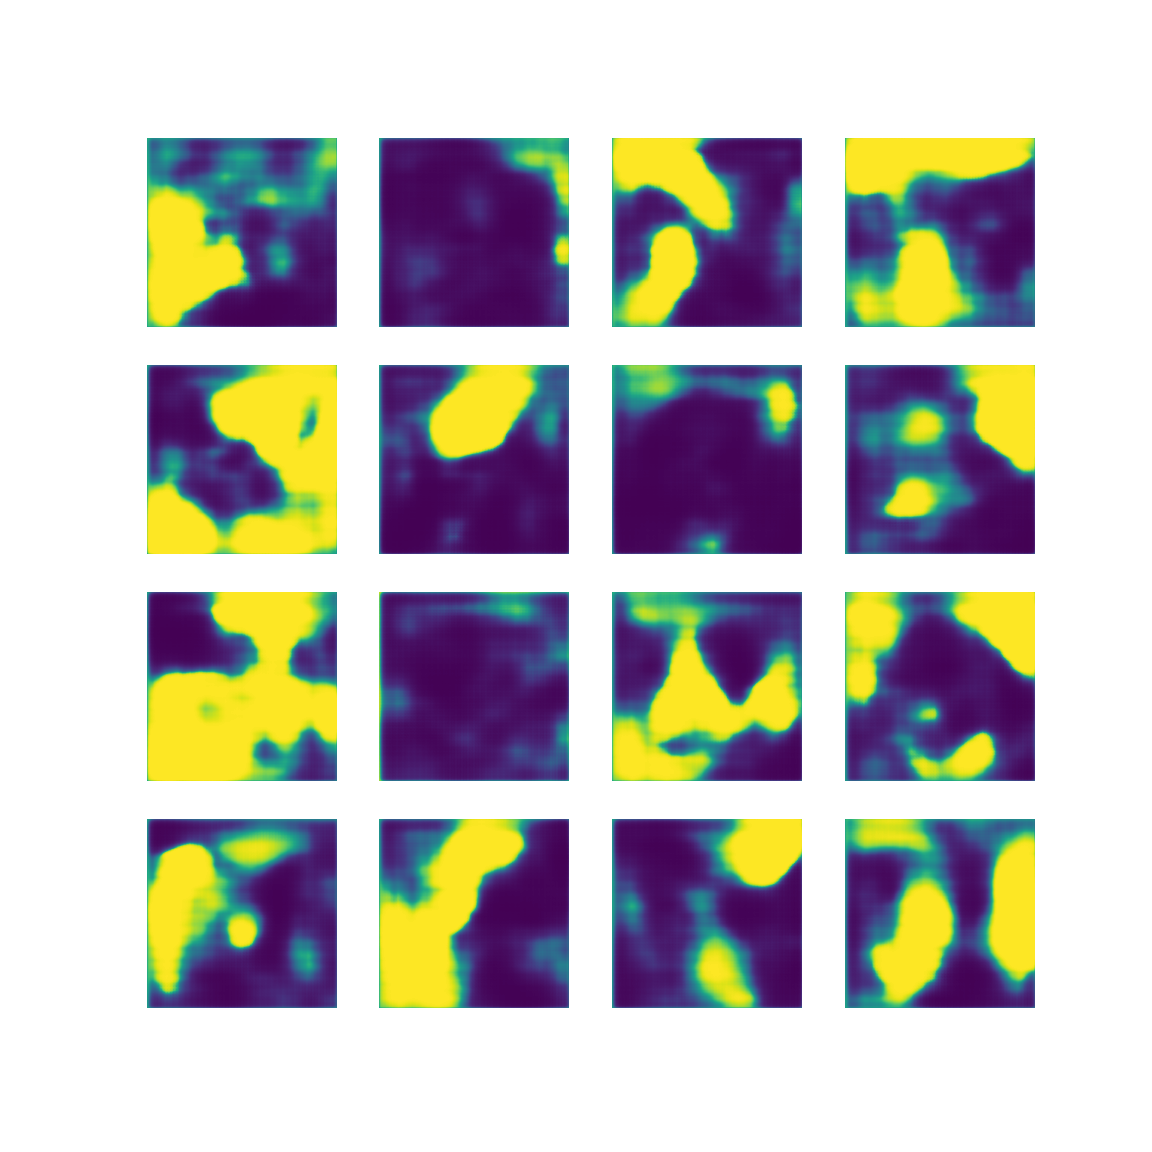

In [31]:
display_image(EPOCHS)

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

## Test Data로 새로운 이미지 생성

In [33]:
!ls {checkpoint_dir}

checkpoint		     ckpt-5.data-00000-of-00002
ckpt-10.data-00000-of-00002  ckpt-5.data-00001-of-00002
ckpt-10.data-00001-of-00002  ckpt-5.index
ckpt-10.index		     ckpt-6.data-00000-of-00002
ckpt-1.data-00000-of-00002   ckpt-6.data-00001-of-00002
ckpt-1.data-00001-of-00002   ckpt-6.index
ckpt-1.index		     ckpt-7.data-00000-of-00002
ckpt-2.data-00000-of-00002   ckpt-7.data-00001-of-00002
ckpt-2.data-00001-of-00002   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00002
ckpt-3.data-00000-of-00002   ckpt-8.data-00001-of-00002
ckpt-3.data-00001-of-00002   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00002
ckpt-4.data-00000-of-00002   ckpt-9.data-00001-of-00002
ckpt-4.data-00001-of-00002   ckpt-9.index
ckpt-4.index


In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [35]:
import cv2
from IPython.display import Image

test_url = '/content/test/test_extract'
img_h, img_w, num_channels = 512, 512, 3

img_test_path = []
for i in folder:
  file_list = os.listdir(i)
  file_list_jpg = [i+'/'+file for file in file_list if file.endswith(".jpg")]
  img_test_path += file_list_jpg
  print(len(file_list_jpg))
print(len(img_test_path))
print(img_test_path)

37
37
40
68
116
298
['/content/train/train/angry/frame261.jpg', '/content/train/train/angry/frame255.jpg', '/content/train/train/angry/frame154.jpg', '/content/train/train/angry/frame146.jpg', '/content/train/train/angry/frame149.jpg', '/content/train/train/angry/frame227.jpg', '/content/train/train/angry/frame131.jpg', '/content/train/train/angry/frame239.jpg', '/content/train/train/angry/frame20.jpg', '/content/train/train/angry/frame9.jpg', '/content/train/train/angry/frame81.jpg', '/content/train/train/angry/frame147.jpg', '/content/train/train/angry/frame256.jpg', '/content/train/train/angry/frame15.jpg', '/content/train/train/angry/frame144.jpg', '/content/train/train/angry/frame231.jpg', '/content/train/train/angry/frame150.jpg', '/content/train/train/angry/frame132.jpg', '/content/train/train/angry/frame228.jpg', '/content/train/train/angry/frame80.jpg', '/content/train/train/angry/frame4.jpg', '/content/train/train/angry/frame238.jpg', '/content/train/train/angry/frame237.jpg'

In [45]:
test = []
for i in img_test_path:
  img = cv2.imread(i)
  img_input = cv2.resize(img, (img_h, img_w))
  img_input = (img_input-127.5)/127.5
  # img_input = img_input[np.newaxis, ...].astype(np.float32) # 차원추가
  img_input = tf.constant(img_input) # numpy array를 tensor로 변경

  test.append(img_input)
print(len(test))
print(len(test[0]))

298
512


In [39]:
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [43]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image','Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
for i in test_dataset.take(5):
  generate_images(generator, i)

ㅠㅠ톰과 제리가ㅠㅠㅠ

- OOM 오류 때문에 batch를 최대한 줄여서 16에서 했는데...에폭을 더 늘리면 될까? 